Problema de Negócio
"...O time de produtos tem dificuldade em determinar a necessidade da maioria dos clientes. O time de marketing enfrenta desafios para determinar o cliente ideal e o time de desenvolvimento sofre com os grandes volumes de acessos no site e em seu aplicativo, causando quedas de sistema e tornando o site inoperante por algumas horas, impedindo as pessoas de comprar e assim, gerando muitas reclamações no atendimento, liderado pelo time de customer experience."

"... Porém, a dificuldade inicial era identificar quais clientes teriam um nível de satisfação “Satisfeito” ou “Neutro/Insatisfeito”, para que o time conseguisse entrar em contato somente com os clientes “Neutro/Insatisfeito”.

Objetivo
Identificar os clientes satisfeitos/insatisfeitos dentro do escopo de atuação de um cientista de dados
Gerar insights através dos dados para os times impactados
Como o Cientista de Dados pode ajudar na resolução
O Cientista de Dados através do conhecimento do negócio, analises estatisticas, aplicação do metodo cientifico na modelagem dos experimento e na cosntrução de modelos de aprendizado de máquina é um profissional que consegue reunir as informações relevantes sobre os clientes e identificar padrões, tendências e possíveis relações entre as variáveis.
Como a solução proposta impacta o negocio
Melhoria da satisfação do cliente: Ao identificar os clientes insatisfeitos ou neutros, o time de atendimento poderá entrar em contato com eles de forma personalizada para entender suas preocupações e buscar soluções. Isso pode levar a um aumento da satisfação do cliente, reduzindo as reclamações e melhorando a imagem da empresa.

Aumento da retenção de clientes: Com o modelo de satisfação, a empresa pode tomar medidas proativas para resolver os problemas dos clientes insatisfeitos antes que eles se tornem um problema maior e optem por não voltar a fazer negócios. Isso pode aumentar a retenção de clientes, aumentando a fidelidade e o valor do ciclo de vida do cliente.

Direcionamento eficiente de marketing: O modelo que determina o cliente ideal pode ajudar o time de marketing a direcionar suas campanhas de forma mais eficiente, concentrando-se nos públicos mais propensos a se tornarem clientes satisfeitos e fiéis. Isso pode melhorar a taxa de conversão de leads em clientes e otimizar os gastos com marketing.

Redução de custo : com uma identificaçao otimizada dos clientes insatisfeitos / neutros, a empresa consegue reduzir os custos operacionais para entrar em contato com os clientes (atendimento ao consumidor), oferecimento de bônus ou promoções específicas para converter esses clientes. Esses recursos podem ser redirecionados para outras áreas a fim de diminuir parte dos problemas citados no enunciado.

In [60]:
# Basic Tools
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from watermark import watermark

# Imputer
from sklearn.impute import KNNImputer
from math import ceil

# Modelos de Machine Learning
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Model Selection Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate, StratifiedKFold

# Model Evaluation Tools
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.preprocessing import RobustScaler, MinMaxScaler, PowerTransformer

# HyperTunning Tools
import optuna

# Feature Importance Tools
import shap
from shap import plots

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

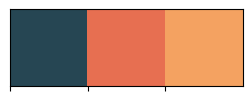

In [61]:
# Configurações de Layout, Matlab e Seaborn
LAYOUT_PALETTE = ["#264653","#e76f51","#f4a261"]
sns.set_palette(sns.color_palette(LAYOUT_PALETTE))

cm = sns.light_palette("#e76f51")

sns.palplot(sns.color_palette(LAYOUT_PALETTE))

In [62]:
print(watermark())


Last updated: 2024-02-10T01:02:48.943097-03:00

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



In [63]:
print(watermark(packages="pandas,numpy,optuna,scikit-learn,lightgbm,xgboost,matplotlib,seaborn,shap"))

pandas      : 2.1.4
numpy       : 1.26.2
optuna      : 3.5.0
scikit-learn: 1.2.2
lightgbm    : 4.1.0
xgboost     : 1.7.3
matplotlib  : 3.8.0
seaborn     : 0.12.2
shap        : 0.42.1



In [64]:
data_train_raw = pd.read_csv('/home/siquette/Documentos/ds/ml/Kaggle/train.csv')
data_test_raw = pd.read_csv('/home/siquette/Documentos/ds/ml/Kaggle/test.csv')

In [65]:
data_train_raw.shape, data_test_raw.shape

((103904, 24), (25976, 23))

In [66]:
df = data_train_raw.copy()
teste = data_test_raw.copy()

In [67]:
def PREPROCESSING(df,verbose=True):
    
    if verbose ==True: 
        print('NaN Antes: ', df.isna().sum().sum())

        #df = df.dropna(axis=0)
        #df['Delivery delay in minutes'] = df['Delivery delay in minutes'].fillna(df['Delivery delay in minutes'].mode()[0])
        #df['Delivery delay in minutes'] = df['Delivery delay in minutes'].fillna(df['Delivery delay in minutes'].median())
        # KNN Imputer
        df['Delivery delay in minutes'] = df['Delivery delay in minutes'].fillna(df['Carrier delay in minutes'])
     
        print('NaN Depois: ', df.isna().sum().sum())

        #Features criadas: Delay
        
    return df

In [68]:
## Aplicando as alterações na base de treino
df = PREPROCESSING(df)

NaN Antes:  310
NaN Depois:  0


In [69]:
## Aplicando as alterações na base de teste
teste = PREPROCESSING(teste)

NaN Antes:  83
NaN Depois:  0


In [70]:
df_eda = df.copy()

In [71]:
def summary_stats(df):
    # central tendency: mean, median   
    numerical_features = df.select_dtypes(include = ['number']).columns.values
    df = df[numerical_features]
    
    count_ = pd.DataFrame(df.apply(np.size))
    sum_ = pd.DataFrame(df.apply(np.sum))
    mean_ = pd.DataFrame(df.apply(np.mean))
    std_ = pd.DataFrame(df.apply(np.std))
    median_ = pd.DataFrame(df.apply(np.median))
    
    min_ = pd.DataFrame(df.apply(min))
    max_ = pd.DataFrame(df.apply(max))
    range_ = pd.DataFrame(df.apply(lambda x: x.max() - x.min()))
    q1_ = pd.DataFrame(df.apply(lambda x: np.percentile(x,25)))
    q3_ = pd.DataFrame(df.apply(lambda x: np.percentile(x,75)))
    
    skewness_= pd.DataFrame(df.apply(lambda x: x.skew()))
    kurtosis_ = pd.DataFrame(df.apply(lambda x: x.kurtosis()))
    
    summary = pd.concat([count_, mean_, std_, median_, sum_, min_, max_, range_, q1_,q3_, skewness_, kurtosis_],axis=1)
    summary.columns = ['counts', 'mean','std','median','sum','min','max', 'range', '25%','75%', 'skew', 'kurt']
 

    cm = sns.light_palette("#e76f51", as_cmap = True)
    
    display(summary.style.format('{:.2f}').background_gradient(subset=(summary.index[2:],summary.columns[:]),cmap=cm))

In [72]:
summary_stats(df)

,counts,mean,std,median,sum,min,max,range,25%,75%,skew,kurt
id,103904.00,64924.21,37463.63,64856.50,6745885168.00,1.00,129880.00,129879.00,32533.75,97368.25,0.00,-1.20
Age,103904.00,39.38,15.11,40.00,4091709.00,7.00,85.00,78.00,27.00,51.00,-0.00,-0.72
Store distance,103904.00,1189.45,997.14,843.00,123588444.00,31.00,4983.00,4952.00,414.00,1743.00,1.11,0.27
InStore wifi,103904.00,2.73,1.33,3.00,283625.00,0.00,5.00,5.00,2.00,4.00,0.04,-0.85
Open/Close time convenient,103904.00,3.06,1.53,3.00,317977.00,0.00,5.00,5.00,2.00,4.00,-0.33,-1.04
Easy of online shopping,103904.00,2.76,1.40,3.00,286453.00,0.00,5.00,5.00,2.00,4.00,-0.02,-0.91
Store location,103904.00,2.98,1.28,3.00,309310.00,0.00,5.00,5.00,2.00,4.00,-0.06,-1.03
Toilet cleaning,103904.00,3.20,1.33,3.00,332714.00,0.00,5.00,5.00,2.00,4.00,-0.15,-1.15
Dressing room,103904.00,3.25,1.35,3.00,337727.00,0.00,5.00,5.00,2.00,4.00,-0.45,-0.70
Waiting room,103904.00,3.44,1.32,4.00,357367.00,0.00,5.00,5.00,2.00,5.00,-0.48,-0.93


Clientes Satisfeitos: 45025
Clientes Neutros/Insatisfeitos: 58879


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


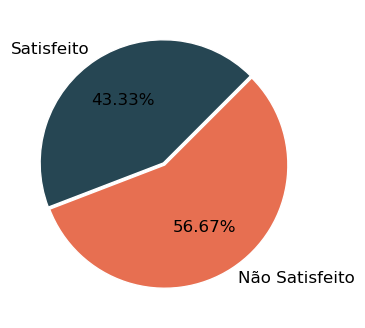

In [73]:
plt.figure(figsize=(4, 4))
plt.pie([len(df_eda.loc[df_eda['Satisfaction'] == 'Satisfied']), 
         len(df_eda.loc[df_eda['Satisfaction'] == 'Neutral or Dissatisfaction'])],
        labels=['Satisfeito', 'Não Satisfeito'],
        colors=['#264653', '#e76f51'],
        explode=(0.01, 0.01),
        startangle=45,
        autopct='%.2f%%',
        wedgeprops={'linewidth': 1, 'edgecolor': "white"},
        textprops={'fontsize': 12});

print(f"Clientes Satisfeitos: {df_eda['Satisfaction'].value_counts()[1]}")
print(f"Clientes Neutros/Insatisfeitos: {df_eda['Satisfaction'].value_counts()[0]}")

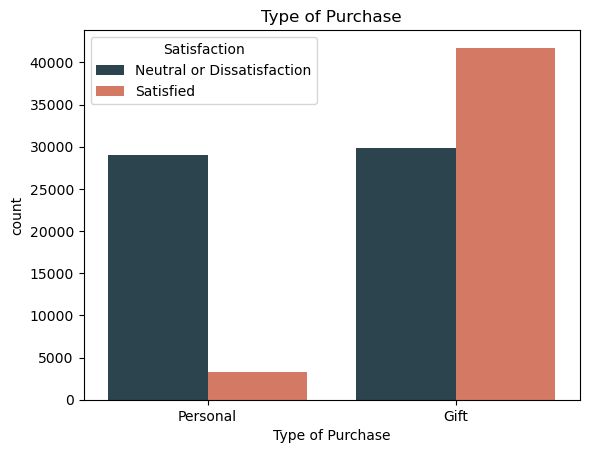

In [74]:
sns.countplot(data=df_eda, x="Type of Purchase", hue="Satisfaction",  palette=LAYOUT_PALETTE)
plt.title("Type of Purchase");

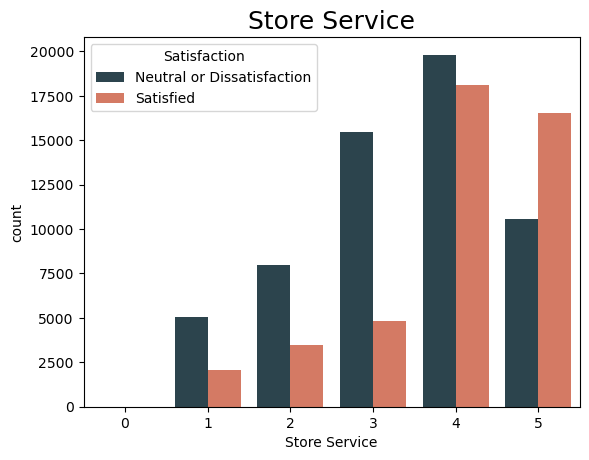

In [75]:
sns.countplot(data=df_eda, x="Store Service", hue='Satisfaction', palette=LAYOUT_PALETTE)
plt.title("Store Service",fontsize=18);

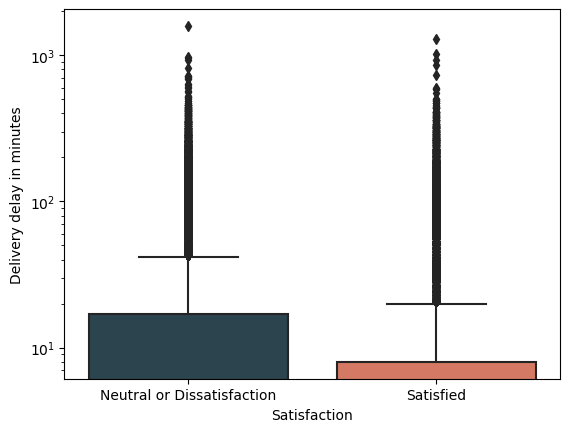

In [76]:
sns.boxplot(data=df, x='Satisfaction', y='Delivery delay in minutes', palette=LAYOUT_PALETTE)
plt.yscale('log')

In [77]:
df_prep = df.copy()


In [78]:
def ENCODING(df, is_train=True):

    gender_dict = {'Male': 0,  'Female':1}
    df['Gender'] = df['Gender'].map(gender_dict)

    customer_dict = {'disloyal Customer': 0,  'Loyal Customer':1}
    df['Customer Type'] = df['Customer Type'].map(customer_dict)

    gift_dict = {'Gift': 0,  'Personal':1}
    df['Type of Purchase'] = df['Type of Purchase'].map(gift_dict)

    size_dict = {'Small': 1, 'Medium':2, 'Large':3}
    df['Store size'] = df['Store size'].map(size_dict)        
                     
    if is_train == True:
        satisfaction_dict = {'Neutral or Dissatisfaction': 0,  'Satisfied':1}
        df['Satisfaction'] = df['Satisfaction'].map(satisfaction_dict)

    return df

In [79]:
def RESCALE(df):
    rs = RobustScaler()
    mms = MinMaxScaler()
    pt = PowerTransformer()
    
    df['Carrier delay in minutes'] = rs.fit_transform( df[['Carrier delay in minutes']].values)
    df['Delivery delay in minutes'] = rs.fit_transform( df[['Delivery delay in minutes']].values)
    df['Store location'] = mms.fit_transform( df[['Store location']].values)
    df['Age'] = mms.fit_transform( df[['Age']].values)
    
    return df

In [80]:
TARGET = 'Satisfaction'

In [81]:
df_prep = ENCODING(df_prep, is_train=True)
df_prep = RESCALE(df_prep)

In [82]:
teste = ENCODING(teste, is_train=False)
teste = RESCALE(teste)

In [83]:
SELECTED_FEATURES = ['id', 
                     'Gender', 
                     'Customer Type', 
                     'Age', 
                     'Type of Purchase',
                     'Store size', 
                     'Store distance', 
                     'InStore wifi',
                     'Open/Close time convenient', 
                     'Easy of online shopping',
                     'Store location', 
                     'Toilet cleaning', 
                     'Dressing room', 
                     'Waiting room',
                     'Kids entertainment', 
                     'Seller service', 
                     'Showroom ', 
                     'Self-Store',
                     'Purchase service', 
                     'Store Service', 
                     'Cleanliness',
                     'Carrier delay in minutes', 
                     'Delivery delay in minutes',
                    ]

In [84]:
y = df_prep[TARGET]
X = df_prep[SELECTED_FEATURES]

In [85]:
X_test = teste[SELECTED_FEATURES]

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((83123, 23), (83123,), (20781, 23), (20781,))

In [87]:
def CM(y, y_pred):
    labels = ["Não Satisfeito / Neutral", "Satisfeito"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")  
    plt.show()
    print("Score: \n", classification_report(y,y_pred))   

In [88]:
def CVS(model, X, y):
   
    number_folds = 5    
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False)    
    y_prob = y_prob[:,1]    
    threshold = 0.5    
    y_pred = np.where(y_prob >= threshold, 1, 0)
    
    CM(y,y_pred)

    scores = cross_validate(model, X, y, cv = Kfold, scoring=['accuracy','precision','recall','f1','roc_auc'], return_train_score=True)
    
    df = pd.DataFrame.from_dict(scores).T
    df['value'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    display(df[['value','std']])    
    
    return y_prob, y_pred

In [89]:
weight = round(float((y.value_counts()[0])/(y.value_counts()[1])),3) #sum_neg/sum_p
weight

1.308

In [90]:
results = df_prep[['Satisfaction']].copy()

In [91]:
def objective(trial):    
   
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary']),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']), 
        'num_leaves': trial.suggest_int('num_leaves', 60, 120, step=5),
        'max_depth': trial.suggest_int('max_depth', 9, 21),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3), 
        #'learning_rate': trial.suggest_categorical('learning_rate', [0.25]),
        #'max_bin': trial.suggest_int('max_bin', 50, 250, step=10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e-1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1e-4, log=True),
        #'min_child_samples': trial.suggest_int('min_child_samples', 1, 8, 1),
        #'num_iterations': trial.suggest_int('num_iterations', 100, 200, step=10),
        #'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, weight]),
        #'boost_from_average': trial.suggest_categorical('boost_from_average', [False, True]),
        'seed': trial.suggest_categorical('seed', [RANDOM_SEED])        
        
    }
    
    model = LGBMClassifier(**param_grid)
    
    number_folds = 3
    kfold = StratifiedKFold(n_splits=number_folds, shuffle=True)
    y_pred = cross_val_predict(model, X, y, cv=kfold)
    
    return f1_score(y, y_pred)

In [92]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=120)
 
trial = study.best_trial

[I 2024-02-10 01:02:53,236] A new study created in memory with name: no-name-c8b8d75d-d346-414b-82ac-1eb365706baa


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 30017, number of negative: 39252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 69269, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433340 -> initscore=-0.268239
[LightGBM] [Info] Start training from score -0.268239
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 30016, number of negative: 39253
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Inf

In [93]:
# Print the result
lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print(f"Best score: {lgbm_best_score}\n")
print(f"Optimized parameters: {lgbm_best_params}\n")

Best score: 0.961292942052196

Optimized parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 65, 'max_depth': 19, 'learning_rate': 0.2852643840510595, 'reg_alpha': 0.01486322259565724, 'reg_lambda': 1.3000640458816215e-06, 'seed': 42}



In [94]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [95]:
fig = optuna.visualization.plot_slice(study, params=["learning_rate", "max_depth", "num_leaves"])#, "reg_alpha", "reg_lambda"])
fig.show()

In [96]:
def plot_lgbm_param_scores(param_name, param_range, fixed_params, X_train, y_train, X_val, y_val):
    
    train_scores = []
    val_scores = []
    
    for param_value in param_range:
        params = fixed_params
        params[param_name] = param_value
        
        lgbm = LGBMClassifier(**params)
        lgbm.fit(X_train, y_train)
        
        train_scores.append(precision_score(y_train, lgbm.predict(X_train)))
        val_scores.append(precision_score(y_val, lgbm.predict(X_val)))
    
    plt.figure(figsize=(8, 4))
    plt.plot(param_range, train_scores, label="Train", color="#264653")
    plt.plot(param_range, val_scores, label="Val", color="#e76f51")

    plt.title("LightGBM")
    plt.xlabel(param_name)
    plt.ylabel("Precision")
    plt.tight_layout()
    plt.legend(loc="best");

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36020, number of negative: 47103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 83123, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433334 -> initscore=-0.268262
[LightGBM] [Info] Start training from score -0.268262
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36020, number of negative: 47103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_c

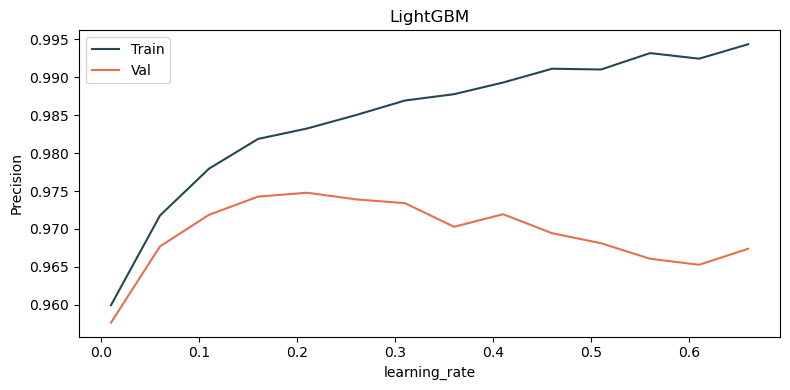

In [97]:
param_name = "learning_rate"
param_range = np.arange(0.01, 0.7, 0.05)
fixed_params = lgbm_best_params.copy()

plot_lgbm_param_scores(param_name, param_range, fixed_params, X_train, y_train, X_val, y_val)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36020, number of negative: 47103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 83123, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433334 -> initscore=-0.268262
[LightGBM] [Info] Start training from score -0.268262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

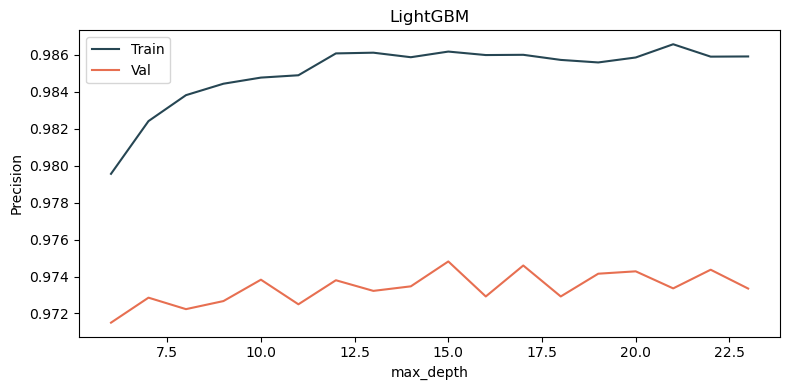

In [98]:
param_name = "max_depth"
param_range = np.arange(6, 24, 1)
fixed_params = lgbm_best_params.copy()

plot_lgbm_param_scores(param_name, param_range, fixed_params, X_train, y_train, X_val, y_val)

In [99]:
lgbm_best_params

{'objective': 'binary',
 'boosting_type': 'dart',
 'num_leaves': 65,
 'max_depth': 19,
 'learning_rate': 0.2852643840510595,
 'reg_alpha': 0.01486322259565724,
 'reg_lambda': 1.3000640458816215e-06,
 'seed': 42}

In [100]:
lgbm_best_params_revised = {'objective': 'binary',
 'boosting_type': 'dart',
 'num_leaves': 65,
 'max_depth': 16,
 'learning_rate': 0.27,
 'reg_alpha': 0.0042,
 'reg_lambda': 1.3e-06,
 'seed': 42}

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 45025, number of negative: 58879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 103904, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433333 -> initscore=-0.268267
[LightGBM] [Info] Start training from score -0.268267
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36020, number of negative: 47103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

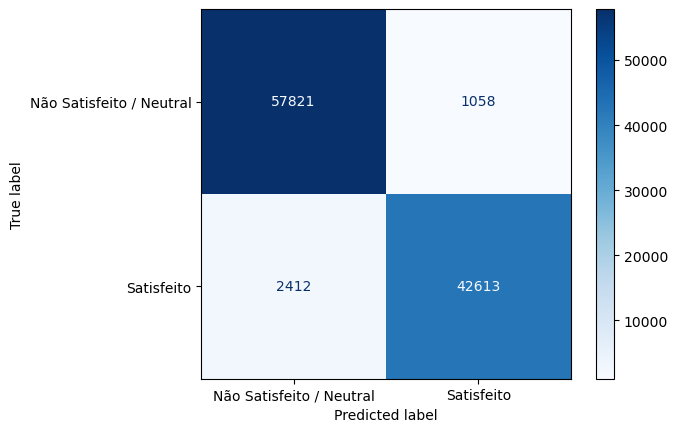

Score: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     58879
           1       0.98      0.95      0.96     45025

    accuracy                           0.97    103904
   macro avg       0.97      0.96      0.97    103904
weighted avg       0.97      0.97      0.97    103904

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36020, number of negative: 47103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 83123, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433334 -> initscore=-0.268262
[LightGBM] [Info] Start training from score -0.268262
[LightGBM] [Warning] Found

,value,std
fit_time,4.389037,0.415726
score_time,0.323631,0.068675
test_accuracy,0.966604,0.000978
train_accuracy,0.975841,0.000417
test_precision,0.975774,0.001138
train_precision,0.985542,0.000470
test_recall,0.946430,0.001328
train_recall,0.958306,0.000604
test_f1,0.960877,0.001150
train_f1,0.971733,0.000490


In [101]:
lgbm_model = LGBMClassifier(**lgbm_best_params_revised)
lgbm_model.fit(X,y)
lgbm_prob, lgbm_pred = CVS(lgbm_model,X,y)

In [102]:
results['lgbm_pred'] = lgbm_pred
results['lgbm_prob'] = lgbm_prob
results.sample(5)

,Satisfaction,lgbm_pred,lgbm_prob
101509,0,0,0.000727
56315,1,1,0.988527
32611,1,1,0.998919
88407,1,1,0.999634
57558,0,0,0.000915


In [103]:
lgbm_model.fit(X, y)
y_test_lgbm = lgbm_model.predict(X_test)
y_test_lgbm

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 45025, number of negative: 58879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 103904, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433333 -> initscore=-0.268267
[LightGBM] [Info] Start training from score -0.268267


array([1, 1, 0, ..., 0, 1, 0])

In [104]:
teste['Satisfaction'] = y_test_lgbm


In [105]:
len(teste), len(data_test_raw)


(25976, 25976)

In [106]:
teste['Satisfaction'].value_counts()


Satisfaction
0    14882
1    11094
Name: count, dtype: int64

In [107]:
def objective(trial): 
    
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary:logistic']),  
        'booster': trial.suggest_categorical('booster', ['gbtree','dart']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['auc']),    
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        #'learning_rate': trial.suggest_categorical('learning_rate', [0.1]),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.25),
        'n_estimators' : trial.suggest_int('n_estimators', 60, 240, step=20),
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-1, log=True),
        'lambda': trial.suggest_float('lambda', 1e-4, 1e-1, log=True),
        #'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),  
        #'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,weight]),
        'seed': trial.suggest_categorical('seed', [RANDOM_SEED]),     
    }

    model = XGBClassifier(**param_grid)
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=False) #random_state=RANDOM_SEED
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    
    return f1_score(y,y_pred)

In [108]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=5) 

trial = study.best_trial

In [109]:
# Print the result
xgb_best_params = study.best_params
xgb_best_score = study.best_value
print(f"Best score: {xgb_best_score}\n")
print(f"Optimized parameters: {xgb_best_params}\n")

Best score: 0.9585830756255272

Optimized parameters: {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 11, 'learning_rate': 0.12559307624535682, 'n_estimators': 160, 'alpha': 0.011785107125855808, 'lambda': 0.0015170501129200286, 'seed': 42}



In [110]:
xgb_best_params


{'objective': 'binary:logistic',
 'booster': 'dart',
 'eval_metric': 'auc',
 'max_depth': 11,
 'learning_rate': 0.12559307624535682,
 'n_estimators': 160,
 'alpha': 0.011785107125855808,
 'lambda': 0.0015170501129200286,
 'seed': 42}

In [111]:
xgb_best_params_revised = {'objective': 'binary:logistic',
 'booster': 'gbtree',
 'eval_metric': 'auc',
 'max_depth': 11,
 'learning_rate': 0.12,
 'n_estimators': 180,
 'alpha': 0.0144,
 'lambda': 0.0022,
 'seed': 42}

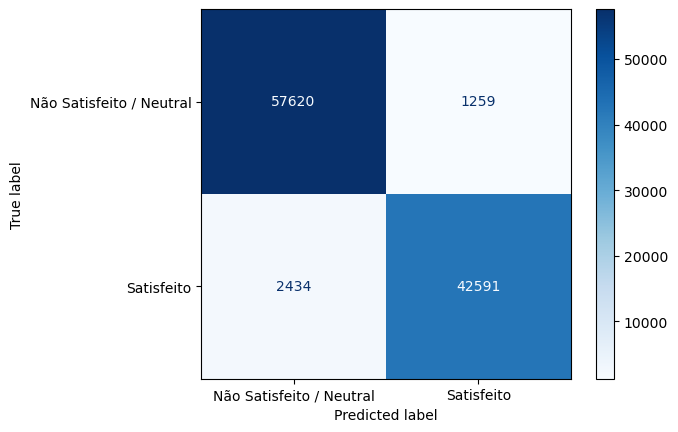

Score: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     58879
           1       0.97      0.95      0.96     45025

    accuracy                           0.96    103904
   macro avg       0.97      0.96      0.96    103904
weighted avg       0.96      0.96      0.96    103904



,value,std
fit_time,32.689716,5.769525e-01
score_time,0.424489,3.895603e-02
test_accuracy,0.964458,9.673832e-04
train_accuracy,0.999808,8.088155e-05
test_precision,0.971290,1.107687e-03
train_precision,0.999889,3.043367e-05
test_recall,0.945941,2.167484e-03
train_recall,0.999667,1.580261e-04
test_f1,0.958446,1.163563e-03
train_f1,0.999778,9.334918e-05


In [112]:
xgb_model = XGBClassifier(**xgb_best_params_revised)
xgb_prob, xgb_pred = CVS(xgb_model,X,y)

In [113]:
results['xgb_pred'] = xgb_pred
results['xgb_prob'] = xgb_prob
results.sample(5)

,Satisfaction,lgbm_pred,lgbm_prob,xgb_pred,xgb_prob
66138,1,1,0.996840,1,0.999963
33755,1,1,0.990159,1,0.999796
41674,1,1,0.999171,1,0.999967
72086,0,0,0.000180,0,0.000015
84690,1,1,0.636074,1,0.828080


In [114]:
xgb_model.fit(X, y)
y_test_xgb = xgb_model.predict(X_test)
y_test_xgb

array([1, 1, 0, ..., 0, 1, 0])

In [115]:
teste['Satisfaction'] = y_test_xgb


In [116]:
len(teste), len(data_test_raw)


(25976, 25976)

In [117]:
teste['Satisfaction'].value_counts()


Satisfaction
0    14845
1    11131
Name: count, dtype: int64

In [118]:
def objective(trial): 
    
    param_grid = {
    'criterion': trial.suggest_categorical('criterion', ['gini','entropy']),      
    'n_estimators': trial.suggest_int('n_estimators', 60, 180, step=20),
    'max_depth': trial.suggest_int('max_depth', 8, 18),
    'min_samples_split': trial.suggest_int('min_samples_split', 3, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3),
    #'max_features': trial.suggest_float('max_features', 0.4, 0.6),
    'random_state': RANDOM_SEED,
}

    model = RandomForestClassifier(**param_grid)

    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=False)
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    
    return f1_score(y,y_pred)

In [119]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=4);

trial = study.best_trial

In [120]:
# Print the result
rf_best_params = study.best_params
rf_best_score = study.best_value
print(f"Best score: {rf_best_score}\n")
print(f"Optimized parameters: {rf_best_params}\n")

Best score: 0.9544710121192269

Optimized parameters: {'criterion': 'entropy', 'n_estimators': 140, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 1}



In [121]:
rf_best_params


{'criterion': 'entropy',
 'n_estimators': 140,
 'max_depth': 16,
 'min_samples_split': 6,
 'min_samples_leaf': 1}

In [122]:
rf_best_params_revised = {'criterion': 'entropy',
 'n_estimators': 100,
 'max_depth': 17,
 'min_samples_split': 5,
 'min_samples_leaf': 1}

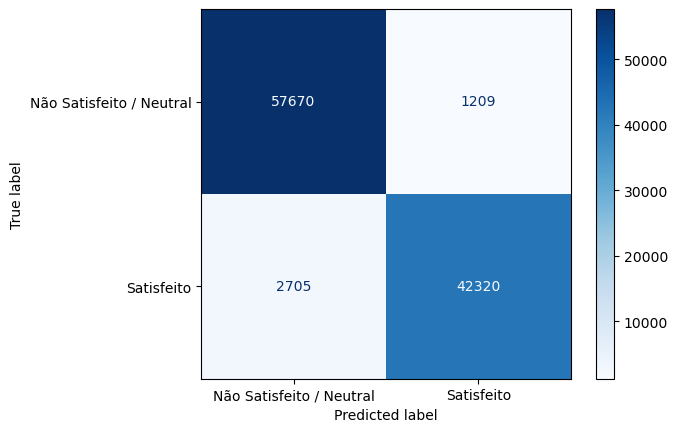

Score: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     58879
           1       0.97      0.94      0.96     45025

    accuracy                           0.96    103904
   macro avg       0.96      0.96      0.96    103904
weighted avg       0.96      0.96      0.96    103904



,value,std
fit_time,13.639657,0.197019
score_time,0.994748,0.017405
test_accuracy,0.961782,0.001244
train_accuracy,0.982770,0.000406
test_precision,0.971734,0.001067
train_precision,0.990950,0.000498
test_recall,0.939123,0.002549
train_recall,0.969089,0.000583
test_f1,0.955148,0.001502
train_f1,0.979898,0.000475


In [123]:
rf_model = RandomForestClassifier(**rf_best_params_revised)
rf_model.fit(X,y)
rf_prob, rf_pred = CVS(rf_model,X,y)

In [124]:
rf_model.fit(X, y)
y_test_rf = rf_model.predict(X_test)
y_test_rf

array([1, 1, 0, ..., 0, 1, 0])

In [125]:
teste['Satisfaction'] = y_test_rf 


In [126]:
len(teste), len(data_test_raw)


(25976, 25976)

In [127]:
teste['Satisfaction'].value_counts()


Satisfaction
0    14892
1    11084
Name: count, dtype: int64

In [128]:
voting = VotingClassifier(estimators=[('LightGBM', lgbm_model), 
                                      ('XGBoost', xgb_model),
                                      ('RandomForest', rf_model)],                          
                                      voting='soft')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 45025, number of negative: 58879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 103904, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433333 -> initscore=-0.268267
[LightGBM] [Info] Start training from score -0.268267
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36020, number of negative: 47103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

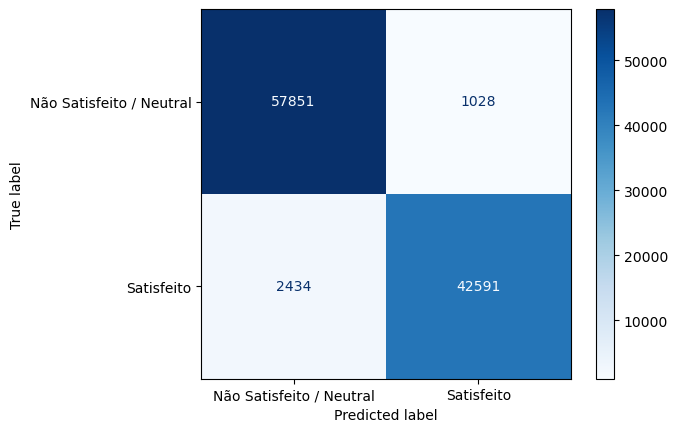

Score: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     58879
           1       0.98      0.95      0.96     45025

    accuracy                           0.97    103904
   macro avg       0.97      0.96      0.97    103904
weighted avg       0.97      0.97      0.97    103904

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36020, number of negative: 47103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 83123, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433334 -> initscore=-0.268262
[LightGBM] [Info] Start training from score -0.268262
[LightGBM] [Warning] Found

,value,std
fit_time,55.347672,1.656102
score_time,1.699831,0.047496
test_accuracy,0.966671,0.000801
train_accuracy,0.993083,0.000361
test_precision,0.976543,0.001168
train_precision,0.997116,0.000261
test_recall,0.945808,0.001993
train_recall,0.986891,0.000688
test_f1,0.960928,0.000968
train_f1,0.991977,0.000420


In [129]:
voting.fit(X,y)
voting_prob, voting_pred = CVS(voting,X,y)

In [130]:
results['voting_pred'] = voting_pred
results['voting_prob'] = voting_prob
results.sample(5)

,Satisfaction,lgbm_pred,lgbm_prob,xgb_pred,xgb_prob,voting_pred,voting_prob
5179,1,1,0.999570,1,0.999987,1,0.999820
4561,1,1,0.564448,1,0.620508,0,0.494256
69189,1,1,0.970124,1,0.959744,1,0.871831
31876,0,0,0.065697,0,0.015919,0,0.066077
93215,0,0,0.001440,0,0.000058,0,0.001703


In [131]:
voting.fit(X, y)
y_test_voting = voting.predict(X_test)
y_test_voting

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 45025, number of negative: 58879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 103904, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433333 -> initscore=-0.268267
[LightGBM] [Info] Start training from score -0.268267


array([1, 1, 0, ..., 0, 1, 0])

In [132]:
teste['Satisfaction'] = y_test_voting


In [133]:
len(teste), len(data_test_raw)


(25976, 25976)

In [134]:
teste['Satisfaction'].value_counts()


Satisfaction
0    14896
1    11080
Name: count, dtype: int64

/home/siquette/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



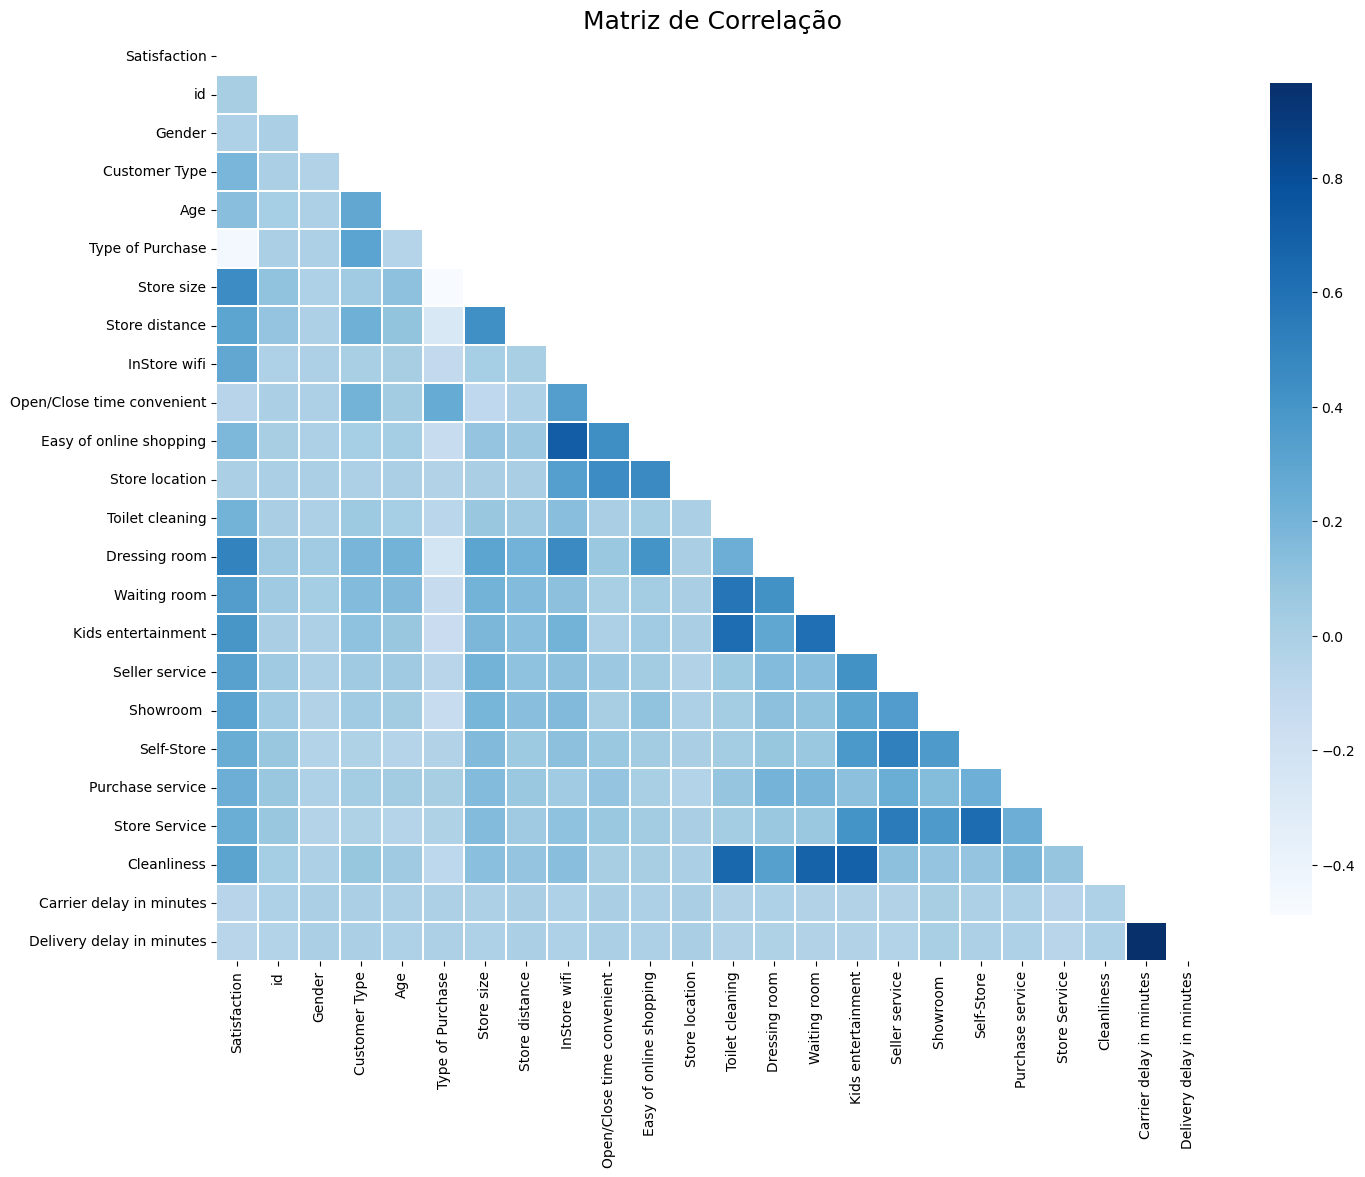

In [135]:
aux = pd.concat([y,X], axis=1)

mask = np.zeros_like(aux.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))

plt.title('Matriz de Correlação',fontsize=18)
sns.heatmap(aux.corr(),linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

In [136]:
lgbm_model.fit(X, y)
explainer = shap.Explainer(lgbm_model, X)
shap_values = explainer(X)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 45025, number of negative: 58879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 103904, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433333 -> initscore=-0.268267
[LightGBM] [Info] Start training from score -0.268267


100%|===================| 103897/103904 [17:56<00:00]        

In [137]:
shap.initjs()


In [138]:
#idx = 196 Satisfeito
#idx = 197 Não Satisfeito
idx = 197

In [139]:
df.iloc[idx,:]


id                                                 56446
Gender                                            Female
Customer Type                             Loyal Customer
Age                                                   52
Type of Purchase                                Personal
Store size                                        Medium
Store distance                                       719
InStore wifi                                           1
Open/Close time convenient                             5
Easy of online shopping                                2
Store location                                         2
Toilet cleaning                                        3
Dressing room                                          5
Waiting room                                           5
Kids entertainment                                     3
Seller service                                         3
Showroom                                               2
Self-Store                     

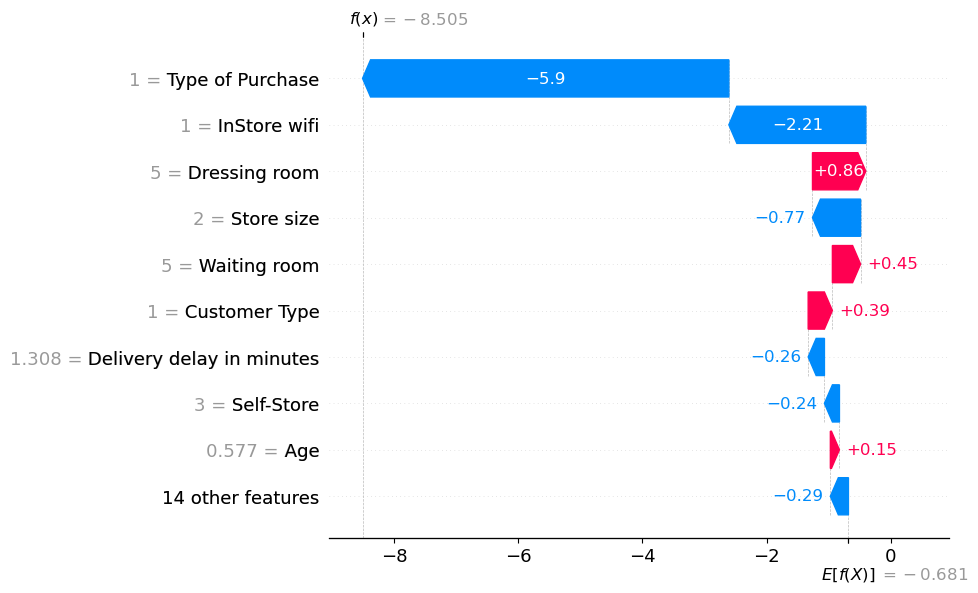

In [140]:
#Explicabilidade individual de acordo com idx
shap.plots.waterfall(shap_values[idx,:])


/home/siquette/anaconda3/lib/python3.11/site-packages/shap/plots/_beeswarm.py:375: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



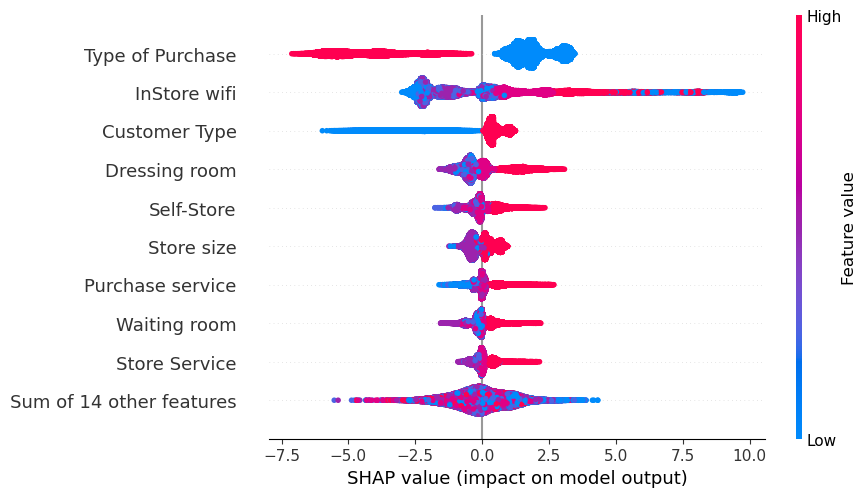

In [141]:
# Explicabilidade Geral, positivo/negativo
shap.plots.beeswarm(shap_values)

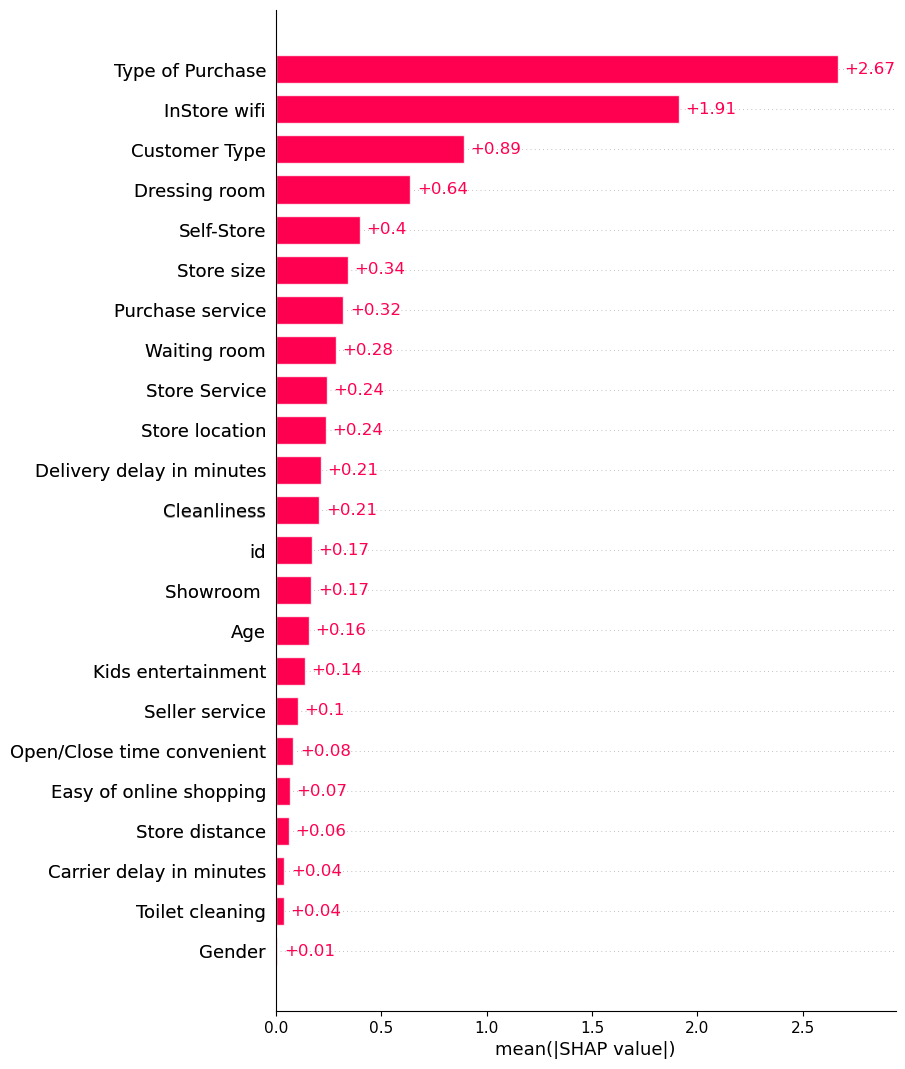

In [142]:
#Explicabilidade Geral, média
shap.plots.bar(shap_values, max_display=25)